## Introduction
TODO: Write some information for the problem definition + the data input and the desired output
Also include some basic information for the tool and how it works


## Case Study


### Create problem object and load instance data


In [8]:
from problem import CAOSProblem
import json

#Load Data
f = open("gen_data.json")
data = json.loads(f.read())
f.close()

### Create problem object and load data
p = CAOSProblem()
p.LoadInstance(data)

## Interest Rate Acceptance Behavior

The acceptance probability of interest rates is modelled using the cumulative distribution function of the logistic distribution.

$$F(x;\mu,s) = \frac{1}{2} + \frac{1}{2} \tanh \left( \frac{x-\mu}{2s} \right)$$

Here $x$ represents an interest rate, while $\mu$ and $s$ are the location and scale parameters, respectively. These parameters can be used to control the shape of the distribution. In CAOS, these parameters can be used to model the behavior of the counterparties regarding the acceptance of suggested interest rates. Moreover, this approach allows for a very robust update of the behavior of a counterparty based on the results of the negotiations.

In the following, we try to visualize the acceptance probability of a range of interest rates for the clients involved in the case study

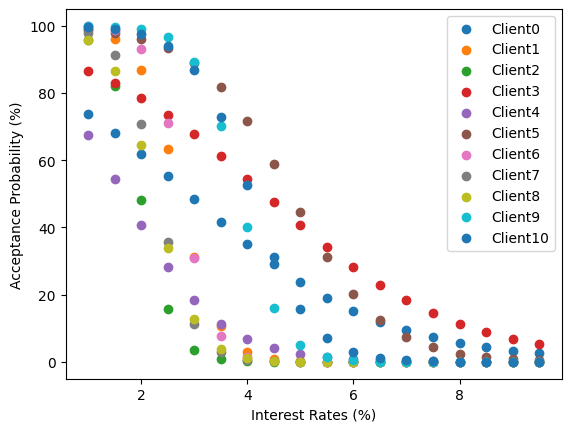

In [9]:
from interest_rate_prediction import InterestRatePrediction
import matplotlib.pyplot as plt

x = [v * 0.5 for v in range(2, 20)]

for c in p.clients:
    y = [InterestRatePrediction.FindRateProbability(c, v) * 100 for v in x]
    plt.scatter(x, y, label=c.name)

plt.xlabel("Interest Rates (%)")
plt.ylabel("Acceptance Probability (%)")
plt.legend()
plt.show()

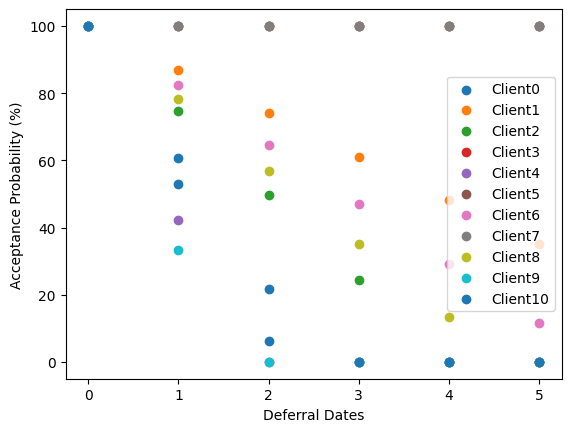

In [11]:
from interest_rate_prediction import InterestRatePrediction
import matplotlib.pyplot as plt

x = range(6)

for c in p.clients:
    y = [InterestRatePrediction.FindDeferralProbability(c, p) * 100 for p in x]
    plt.scatter(x, y, label=c.name)

plt.xlabel("Deferral Dates")
plt.ylabel("Acceptance Probability (%)")
plt.legend()
plt.show()

### Overall Problem Report

In [3]:
p.Report()

#######################
### Instance Statistics
### Total Periods: 11
### Total Contracts: 38
### Total CounterParties 11
#######################
### Inbound Contracts:
#	 ID: 0 	 Period: 5 	 Client: Client3  	 Amount: 4000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 1 	 Period: 1 	 Client: Client9  	 Amount: 6000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 2 	 Period: 0 	 Client: Client7  	 Amount: 2000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 3 	 Period: 8 	 Client: Client0  	 Amount: 6000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 4 	 Period: 5 	 Client: Client1  	 Amount: 4000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 5 	 Period: 1 	 Client: Client6  	 Amount: 5000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 6 	 Period: 8 	 Client: Client3  	 Amount: 6000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 7 	 Period: 1 	 Client: Client4  	 Amount: 1000 	 Type: ContractStatus.UNDER_NEGOTATION
#	 ID: 8 	 Period: 2 	 Client: Client3  	 Amount: 4000 	 Type: Contract

### Solve

In [4]:
p.Solve()

d:\Projects\Consulting\AiPlan4EU\Code\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '256680904651031/9007199254740992'
  warn(
d:\Projects\Consulting\AiPlan4EU\Code\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '8928034417541119/4398046511104'
  warn(
d:\Projects\Consulting\AiPlan4EU\Code\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '5013773022658561/2199023255552'
  warn(
d:\Projects\Consulting\AiPlan4EU\Code\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '5952022945027413/8796093022208'
  warn(
d:\Projects\Consulting\AiPlan4EU\Code\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the rea

## Results

In [7]:
p.PostProcess()


AttributeError: 'NoneType' object has no attribute 'toDict'